<a href="https://colab.research.google.com/github/MeiTao87/computer_vision_projects/blob/main/siamese_network_for_Face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import cv2
import os
from os import listdir
from os.path import isfile, join
from  scipy import ndimage
import numpy as np
from keras.layers.core import Lambda
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
import matplotlib.pyplot as plt

In [36]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def build_base_model(input_shape, dtype=None):
    input_shape = (input_shape[0], input_shape[1], 3)
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    return model


def get_siamese_model(base_model, input_shape, dtype=None):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    # Define the tensors for the two input images
    input_shape = (input_shape[0], input_shape[1], 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    # Generate the encodings (feature vectors) for the two images
    encoded_l = base_model(left_input)
    encoded_r = base_model(right_input)
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    # return the model
    return siamese_net


def build_inference_model(base_model, input_shape, dtype=None):
    # Define the tensors for the two input images
    input_shape = (input_shape[0], input_shape[1], 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    # Generate the encodings (feature vectors) for the two images
    encoded_l = base_model(left_input)
    encoded_r = base_model(right_input)
    model = Model(inputs=[left_input,right_input],outputs=[encoded_l, encoded_r])
    # return the model
    return model


In [32]:
def show(image, label):
  plt.figure()
  plt.imshow(image[0])
  # plt.title(labels[label])
  plt.title(label)
  plt.axis('off')

In [33]:
def tripletDataGenerator(file_path,batch_size=32,training=True):
    sub_folder_list = [os.path.join(file_path, f) for f in listdir(file_path) if not isfile(join(file_path, f))] # ['mt', 'zwq']
    # randomly choose one folder as anchor and positive
    L_folder_path = os.path.join(file_path, sub_folder_list[0])
    R_folder_path = os.path.join(file_path, sub_folder_list[1])
    L_img_path = []
    R_img_path = []
    for img in os.listdir(L_folder_path):
        if img.endswith('face.jpg'):
            L_img_path.append(os.path.join(L_folder_path, img))
    for img in os.listdir(R_folder_path):
        if img.endswith('face.jpg'):
            R_img_path.append(os.path.join(R_folder_path, img))

    # Creating the images batches to feed into network
    img_L = np.zeros((batch_size,105,105,3),dtype=np.float32)
    img_R = np.zeros((batch_size,105,105,3),dtype=np.float32)

    #Dummy label variable
    batch_label = np.zeros((batch_size, 1),dtype=np.float32)

    while True:
        for j in range(batch_size):
            choice = np.random.randint(2)
            if np.random.random() <= 0.5:
                # Selecting from the same folder
                if np.random.random() >= 0.5:
                    l_img_path = L_img_path[np.random.randint(len(L_img_path))]
                    r_img_path = L_img_path[np.random.randint(len(L_img_path))]
                else:
                    l_img_path = R_img_path[np.random.randint(len(R_img_path))]
                    r_img_path = R_img_path[np.random.randint(len(R_img_path))]
                label = 1
            else: # Selecting from different folders
                l_img_path = L_img_path[np.random.randint(len(L_img_path))]
                r_img_path = R_img_path[np.random.randint(len(R_img_path))]
                label = 0
            if training:
                l_img = plt.imread(l_img_path)
                l_img = ndimage.rotate(l_img,np.random.randint(-10,10))
                l_img = cv2.resize(l_img, (105, 105))
                l_img = l_img.astype(np.float32)/255.
                img_L[j] = l_img

                r_img = plt.imread(r_img_path)
                r_img = ndimage.rotate(r_img,np.random.randint(-10,10))
                r_img = cv2.resize(r_img, (105, 105))
                r_img = r_img.astype(np.float32)/255.
                img_R[j] = r_img
                batch_label[j] = label
            else: # not training
                l_img = plt.imread(l_img_path)
                l_img = cv2.resize(l_img, (105, 105))
                l_img = l_img.astype(np.float32)/255.
                img_L[j] = l_img

                r_img = plt.imread(r_img_path)
                r_img = cv2.resize(r_img, (105, 105))
                r_img = r_img.astype(np.float32)/255.
                img_R[j] = r_img
                batch_label[j] = label
        yield (img_L,img_R), batch_label

<class 'tuple'>
(32, 105, 105, 3)
(32, 1)


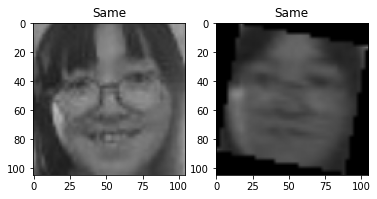

NOT same


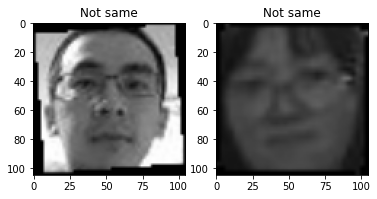

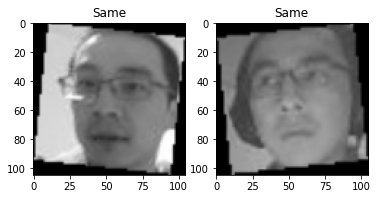

In [63]:
data = next(tripletDataGenerator(file_path='/content/drive/MyDrive/face_data'))
print(type(data[0]))
print(data[0][0].shape)
print(data[1].shape)
for i in range(3):
    l = data[0][0][i]
    r = data[0][1][i]
    label = data[1][i]
    if label[0] == 0:
        print('NOT same')
        title = 'Not same'
    else:
        title = 'Same'
    plt.subplot(1,2,1)
    plt.title(label=title)
    plt.imshow(l)
    plt.subplot(1,2,2)
    plt.title(label=title)
    plt.imshow(r)
    plt.show()

In [35]:
input_shape = (105, 105)
base_model = build_base_model(input_shape=input_shape)
model = get_siamese_model(base_model, input_shape)
model.summary()
batch_size = 16
file_path = '/content/drive/MyDrive/face_data'
model.compile(optimizer='Adam', loss='binary_crossentropy')
with tf.device('/gpu:0'):
    model.fit(tripletDataGenerator(file_path=file_path,training=True),epochs=20, steps_per_epoch=200,verbose=1, validation_data=tripletDataGenerator(file_path=file_path,training=False), validation_steps=30)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1024)         21623104    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           sequential_4[0][0]         

In [57]:
# save base model
base_model.save('base_model1.h5')
base_model.save_weights("ckpt")
# base_model.save('saved_model/base_model')

In [58]:
# build_inference_model
input_shape = (105, 105)
base_model = build_base_model(input_shape=input_shape)
base_model.load_weights("ckpt")
inference_model = build_inference_model(base_model, (105, 105))
inference_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         21623104    input_9[0][0]                    
                                                                 input_10[0][0]                   
Total params: 21,623,104
Trainable params: 21,623,104
Non-trainable params: 0
__________________________________________________________________________________________________


In [59]:
def preprocess(img1,img2):
  img1 = cv2.resize(img1,(105,105))
  img1.astype(np.float32)/255.

  img2 = cv2.resize(img2,(105,105))
  img2.astype(np.float32)/255.
  
  img1 = img1.reshape(-1,105,105,3)
  img2 = img2.reshape(-1,105,105,3)
  return img1,img2

In [60]:
from scipy import spatial
def inference(inputs):
  img1,img2 = inputs
  img1,img2 = preprocess(img1,img2)
  x1,x2 = inference_model.predict((img1,img2))
  print(x1, x2)
  dist = spatial.distance.cosine(x1, x2)
  print(dist)
  if(dist<0.5):
    print("SAME")
  else:
    print("DIFFERENT")

In [61]:
img1 = plt.imread('/content/drive/MyDrive/face_data/mt/10face.jpg')
img2 = plt.imread('/content/drive/MyDrive/face_data/zwq/15face.jpg')
inference((img1,img2))

[[0.0000000e+00 0.0000000e+00 9.9993372e-01 ... 1.0000000e+00
  4.1235847e-08 0.0000000e+00]] [[0.0000000e+00 0.0000000e+00 9.9993372e-01 ... 1.0000000e+00
  4.1235847e-08 0.0000000e+00]]
0.0
SAME


In [41]:
class DataGenerator(Sequence):
    def __init__(self, file_path, batch_size=1, shuffle=False, probability=0.5, imshape=(105,105)):
        self.shuffle = shuffle
        self.file_path = file_path 
        self.batch_size = batch_size
        self.probability = probability # probability of choose same person
        self.imshape = imshape
        # self.on_epoch_end()
        sub_folder_list = [os.path.join(self.file_path, f) for f in listdir(self.file_path) if not isfile(join(self.file_path, f))] # ['mt', 'zwq']
        choose_folder_index = np.random.randint(0, len(sub_folder_list)) # 0 or 1
        chosen_folder_path = os.path.join(self.file_path, sub_folder_list[choose_folder_index])
        # for my case, there are just two folders
        not_chosen_folder_path = os.path.join(self.file_path, sub_folder_list[1 - choose_folder_index])
        # put imgs(path) in chosen folder into one list,
        # other imgs(path) in others folders into another list
        self.chosen_img_path = []
        self.not_chosen_img_path = []
        for img in os.listdir(chosen_folder_path):
            if img.endswith('face.jpg'):
                self.chosen_img_path.append(os.path.join(chosen_folder_path, img))
        for img in os.listdir(not_chosen_folder_path):
            if img.endswith('face.jpg'):
                self.not_chosen_img_path.append(os.path.join(not_chosen_folder_path, img))
        
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.chosen_img_path) / self.batch_size))

    def __getitem__(self, batch_size):
        X = np.zeros((self.batch_size, 2, self.imshape[0], self.imshape[1], 3)) 
        y = np.empty((self.batch_size, 1),  dtype=np.uint8) 
        # for i in range(self.batch_size):
        while True:
            dice = np.random.random()
            if dice <= self.probability: # choose from same folder
                if np.random.random() >= 0.5:
                    img_list = self.not_chosen_img_path
                else:
                    img_list = self.chosen_img_path 
                img_L = cv2.imread(img_list[np.random.randint(0, len(img_list))])
                img_R = cv2.imread(img_list[np.random.randint(0, len(img_list))])
                img_L, img_R = cv2.resize(img_L, self.imshape), cv2.resize(img_R, self.imshape)
                # X[i][0], X[i][1] = img_L, img_R
                y[i,] = 1
            else: # choose from different folders
                img_L = cv2.imread(self.chosen_img_path[np.random.randint(0, len(self.chosen_img_path))])
                img_R = cv2.imread(self.not_chosen_img_path[np.random.randint(0, len(self.not_chosen_img_path))])
                img_L, img_R = cv2.resize(img_L, self.imshape), cv2.resize(img_R, self.imshape)
                # X[i][0], X[i][1] = cv2.resize(img_L, self.imshape), cv2.resize(img_R, self.imshape)
                y[i,] = 0
        return (img_L, img_R), y